<a href="https://colab.research.google.com/github/HyunLee103/Pytorch_practice/blob/master/Pytorch_tutorial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사용자 정의 DATASET, DATALOADER, TRANSFORMS 
 landmark가 찍힌 얼굴 dataset

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 경고 메시지 무시하기
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # 반응형 모드

In [0]:
a = torch.FloatTensor(4, 4).normal_()[0]

In [0]:
a

tensor([-1.0697, -0.4655,  2.1997, -1.2922])

In [8]:
cd /content/drive/My Drive

/content/drive/My Drive


In [0]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

In [10]:
landmarks_frame.shape

(69, 137)

In [11]:
landmarks_frame.head(5)

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,part_4_y,part_5_x,part_5_y,part_6_x,part_6_y,part_7_x,part_7_y,part_8_x,part_8_y,part_9_x,part_9_y,part_10_x,part_10_y,part_11_x,part_11_y,part_12_x,part_12_y,part_13_x,part_13_y,part_14_x,part_14_y,part_15_x,part_15_y,part_16_x,part_16_y,part_17_x,part_17_y,part_18_x,part_18_y,part_19_x,...,part_48_x,part_48_y,part_49_x,part_49_y,part_50_x,part_50_y,part_51_x,part_51_y,part_52_x,part_52_y,part_53_x,part_53_y,part_54_x,part_54_y,part_55_x,part_55_y,part_56_x,part_56_y,part_57_x,part_57_y,part_58_x,part_58_y,part_59_x,part_59_y,part_60_x,part_60_y,part_61_x,part_61_y,part_62_x,part_62_y,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,139,49,150,60,159,73,166,87,168,100,166,111,160,120,151,128,141,133,128,137,116,138,102,138,89,44,70,53,66,63,...,71,137,78,131,85,127,90,129,94,129,99,134,103,142,97,144,92,145,88,145,83,144,77,141,75,137,85,134,89,135,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,320,100,340,111,359,126,375,149,379,175,376,197,364,218,346,236,322,249,296,254,266,256,237,256,207,65,210,69,197,80,...,110,314,117,310,126,308,135,309,147,307,164,306,184,307,167,317,152,321,139,323,130,322,120,318,114,313,127,312,136,313,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,169,80,180,91,189,103,195,115,197,128,197,139,192,148,184,154,173,160,162,164,150,169,138,171,126,80,101,87,95,98,...,101,163,109,157,117,155,123,157,129,156,134,160,139,168,133,171,126,172,120,172,114,171,107,168,104,162,116,161,122,162,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,220,89,238,108,255,129,268,155,268,180,261,203,244,222,224,238,199,247,172,248,144,245,116,241,87,39,114,45,102,57,...,98,207,107,199,120,193,131,193,142,188,162,185,184,187,168,206,151,218,139,222,127,223,113,219,103,206,122,203,133,201,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,536,186,567,214,594,249,614,290,616,329,608,363,589,390,562,411,529,421,491,425,450,425,409,423,370,162,345,178,330,200,...,228,514,246,502,264,495,278,499,292,495,315,502,341,511,318,530,297,538,281,539,266,537,248,529,239,513,265,507,278,509,293,507,331,511,294,516,279,518,265,516


n 번째 사진, landmarks extract 
landmarks는 총 68개가 있고, 각 지점이 x,y 좌표값을 가지므로 총 136개 데이터 값이 생긴다

In [12]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2) # x,y 좌표를 각 채널로 

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


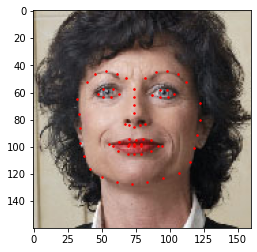

In [13]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # 갱신이 되도록 잠시 멈춥니다.

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

## Dataset Class
이제 데이터셋 클래스를 만들어보도록 하겠습니다. __init__ 을 사용해서 CSV 파일 안에 있는 데이터를 읽지만, __getitem__ 을 이용해서 이미지의 판독을 합니다. 이 방법은 모든 이미지를 메모리에 저장하지 않고 필요할때마다 읽기 때문에 메모리를 효율적으로 사용합니다??

In [0]:
class FaceLandmarksDataset(Dataset): # Dataset(torch.utils.data.Dataset) 데이터 셋을 나타내는 추상클래스, 우리의 데이터셋을 여기에 상속, 아래와 같이 오버라이드

  def __init__(self, csv_file,root_dir,transform=None): # transfrom은 기본 전처리 적용해주는 argu, 여기서는 None
    self.landmarks_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return len(self.landmarks_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = os.path.join(self.root_dir,self.landmarks_frame.iloc[idx,0]) # idx 번째 이미지 이름 경로
    image = io.imread(img_name)
    landmarks = self.landmarks_frame.iloc[idx,1:]
    landmarks = np.array([landmarks])
    landmarks = landmarks.astype('float').reshape(-1,2) # x,y좌표 형태로 
    sample = {'image':image,'landmarks':landmarks}

    if self.transform:
      sample = self.transform(sample)

    return sample


0 (324, 215, 3) (68, 2)


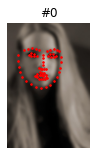

1 (500, 333, 3) (68, 2)


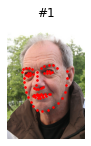

2 (250, 258, 3) (68, 2)


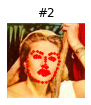

3 (434, 290, 3) (68, 2)


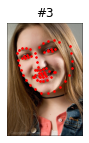

In [18]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv', root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
  sample = face_dataset[i]

  print(i,sample['image'].shape, sample['landmarks'].shape)

  ax = plt.subplot(1,4,i+1)
  plt.tight_layout()
  ax.set_title('#{}'.format(i))
  ax.axis('off')
  show_landmarks(**sample) # **dict : unpacking

  if i==3:
    plt.show()
    break

## Transformer
위에서 볼 수 있었던 한가지 문제점은 샘플들이 다 같은 사이즈가 아니라는 것입니다. 대부분의 신경망(neural networks)은 고정된 크기의 이미지라고 가정합니다. 그러므로 우리는 신경망에 주기 전에 처리할 과정을 작성해야 합니다.

3가지의 transforms 을 만들어 봅시다: 
- Rescale: 이미지의 크기를 조절합니다. 
- RandomCrop: 이미지를 무작위로 자릅니다.
- ToTensor: numpy 이미지에서 torch 이미지로 변경합니다.

이것을 data augmentation이라 합니다.



간단한 함수대신에 호출 할 수 있는 클래스로 작성 합니다. 이렇게 한다면, 클래스가 호출 될 때마다 전이(Transform)의 매개변수가 전달 되지 않아도 됩니다. 이와 같이, __call__ 함수를 구현해야 합니다. 필요하다면, __init__ 함수도 구현해야 합니다. 다음과 같이 전이(transform)를 사용할 수 있습니다.

In [0]:
class Rescale(): # 주어진 값으로 이미지 크기 조정 > output_size로 int, tuple을 받음
  def __init__(self,output_size):
    assert isinstance(output_size,(int,tuple)) # output_size가 int,tuple이 아니면 assert error
    self.output_size = output_size

  def __call__(self,sample):
    image, landmarks = sample['image'],sample['landmarks']

    h,w = image.shape[:2]
    if isinstance(self.output_size,int):
      if h > w :
        new_h,new_w = self.output_size * h/w, self.output_size
      else:
        new_h,new_w = self.output_size, self.output_size
    else:
      new_h, new_w = self.output_size
    
    img = transform.resize(image,(new_h,new_w))
    landmarks = landmarks * [new_w / w, new_h / h]

    return {'image':img, 'landmarks':landmarks}


class RandomCrop():
  def __init__(self,output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      self.output_size = (output_size,output_size)
    else:  
      assert len(output_size) == 2
      self.output_size = output_size

  def __call__(self, sample):
    image, landmarks = sample['image'], sample['landmarks']

    h,w = image.shape[:2]
    new_h, new_w = self.output_size
       
    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)   
    image = image[top: top + new_h, left: left + new_w]

    landmarks = landmarks - [left, top]

    return {'image': image, 'landmarks': landmarks}


class ToTensor():
  def __call__(self,sample):
    image, landmarks = sample['image'], sample['landmarks']

    image = image.transpose((2,0,1)) # 텐서 순서 (채널, H, W)

    return {'image':torch.from_numpy(image), 'landmarks':torch.from_numpy(landmarks)}


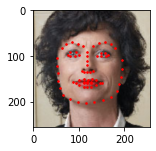

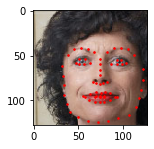

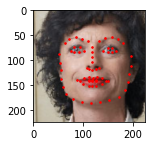

In [26]:
# 각 class를 instance에 할당
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),RandomCrop(224)]) # 여러 transform을 한번에 모아줌

fig = plt.figure()
sample = face_dataset[65]
for i, trs in enumerate([scale,crop,composed]):  
    transformed_sample = trs(sample)                # class 호출

    ax = plt.subplot(1,3,i+1)
    plt.tight_layout()
    show_landmarks(**transformed_sample)

In [0]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

In [0]:
dataloader = DataLoader(transformed_dataset, batch_size=4,shuffle=True, num_workers=4)